# Extensions and packages

In [6]:
# Black formater in Jupyter Notebook.
%load_ext lab_black

# Matplotlib graphs will be included in notebook, next to the code.
%matplotlib inline

# Renders figures as svgs instead of pngs so that they can be saved as pdf or svg via
# the icon in the top right corner of the ouput cell and have higher resolution in the
# Notebook. Note that the figures will be displayed smaller in the output cell as the
# figure dpi does no longer scale the figure since its now a vector graphic.
# %config InlineBackend.figure_format = 'svg'

In [7]:
import locale
import os
import pytexit
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sp

from mypy_extensions import VarArg
from scipy import constants, odr, optimize
from typing import Callable, Iterable, Optional, Sequence, Tuple, Type, Union
from uncertainties import ufloat, unumpy

# Library

#### Latexify

In [8]:
def error_prop_latexify(func: str, variables: Iterable[str]) -> None:
    """
    Calculate the error of a function according to gaussian error propagation and print
    its LaTeX expression as well as the passed function.

    Parameters
    ----------
    func : str
        Function to which the error propagation is to be applied.

        It must be passed in Python syntax but without package syntax such as math.sin,
        np.sin or sp.sin.

        The functions arcsin, arccos and arctan have to be called as asin, acos and
        atan, respectively.
        
        For further deviating expressions visit:
        https://docs.sympy.org/latest/modules/functions/elementary.html

    variables : array_like of rank-1
        The variables to derive to. They must be passed in string format listed in an
        iterable such as list, tuple or set.

    Examples
    --------
    >>> error_prop_latexify("m_ji*x+b*erf(x)", ("m_ji", "b"))
    \sqrt{\left(x u\left(m_{ji}\\right)\\right)^2+\left(1u\left(n\\right)\\right)^2}
    >>> error_prop_latexify("sin(x**a_ij*3) + b*erfc(x)", ("a_ij", "b"))
    \sqrt{\left(3x^{a_{ij}} \ln\left(x\\right)\cos\left(3x^{a_{ij}}\\right) 
    u\left(a_{ij}\\right)\\right)^2+\left(\operatorname{erfc}\left(x\\right) 
    u\left(b\\right)\\right)^2}

    """
    # The derivatives that are necessary for the error propagation are calculated using
    # the sympy package and are added to the list parts_of_err_prop_eq as strings plus
    # the necessary operators to complete the overall result. By using the pytexit pack-
    # age, the joined string err_prop_eq is then transformed into LaTeX code, edited to
    # make the equation look more appealing and returned.
    err_prop_eq = ""
    parts_of_err_prop_eq = []

    # Raise an error, if either of the parameters has the wrong format.
    if not isinstance(func, str):
        raise TypeError(
            f"Not a valid format for func: {type(func)!r}. Format must be str."
        )

    if (
        not isinstance(variables, tuple)
        and not isinstance(variables, list)
        and not isinstance(variables, set)
    ) or not all([isinstance(variable, str) for variable in variables]):
        raise TypeError(
            f"Not a valid format for variables: {variables!r}. "
            + "The variables must be passed in string format listed in a list, "
            + "tuple or set."
        )

    # Set up to calculate the derivatives using the sympy package.
    expr = sp.parse_expr(func)
    symbols = sp.symbols(variables)

    # Calculate the derivatives and add them as strings to parts_of_err_prop_eq
    # together with the necessary operators to complete the overall result.
    parts_of_err_prop_eq.append("sqrt(")

    for count, symbol in enumerate(symbols):
        parts_of_err_prop_eq.append(f"({sp.diff(expr, symbol)}*u({symbol}))**2")
        if count <= len(variables) - 2:
            parts_of_err_prop_eq.append("+")

    parts_of_err_prop_eq.append(")")

    err_prop_eq = "".join(parts_of_err_prop_eq)

    # Clean up the err_prop_eq to make the equation look more appealing in LaTeX.
    err_prop_eq_latexify = pytexit.py2tex(
        err_prop_eq, tex_enclosure="", print_latex=False, print_formula=False
    )
    symbols_to_replace = [
        ("\operatorname{u}", "u"),
        ("sin\left(", "\sin\left("),
        ("cos\left(", "\cos\left("),
        ("tan\left(", "\\tan\left("),
        ("sinh\left(", "\sinh\left("),
        ("cosh\left(", "\cosh\left("),
        ("tanh\left(", "\\tanh\left("),
    ]
    for old_symbol, new_symbol in symbols_to_replace:
        err_prop_eq_latexify = err_prop_eq_latexify.replace(old_symbol, new_symbol)

    # Print and return the input as well as the result.
    print("Input:\n" + func + "\nLaTeX code:")
    pytexit.py2tex(func, tex_enclosure="", print_latex=False)
    pytexit.py2tex(func, tex_enclosure="$", print_formula=False)

    print("\nError propagation LaTeX code:\n" + err_prop_eq_latexify)
    pytexit.py2tex(err_prop_eq, tex_enclosure="$", print_formula=False)

#### Calculations

In [9]:
def mean_error(values: Sequence[Union[float, int]]) -> float:
    """
    Calculate the statistical uncertainty of a mean value according to the "Guide to the
    Expression of Uncertainty in Measurement" (GUM).

    It is assumed that the values are normally distributed and that the interval -t to
    +t encompasses 68.27% of the distribution.

    Therefore, the degree of freedom is determined by n - 1, where n is the number of
    independent observations.

    For further informations visit:
    https://www.bipm.org/en/committees/jc/jcgm/publications

    Parameters
    ----------
    values : array_like of rank-1
        Values from which the mean value and its statistical uncertainty are to be
        determined. Must be an iterable of at least two values.

    Returns
    -------
        mean_error : float
            Statistical uncertainty of the mean according to the t-distribution.

    Example
    -------
    >>> mean_error(np.arange(10))
    1.0148727342217185
    """
    # Calculate the number of independent observations. Raise an error if its not valid.
    n = len(values)

    if n <= 1:
        raise ValueError(
            f"Not a valid length of values: {len(values)!r}. "
            + "Must contain at least two values."
        )

    # Calculate the degrees of freedom.
    degrees_of_freedom = n - 1

    # Determine the t-value from the degrees of freedom.
    if degrees_of_freedom <= 9:
        t = np.array([1.84, 1.32, 1.20, 1.14, 1.11, 1.09, 1.08, 1.07, 1.06])[
            degrees_of_freedom - 1
        ]

    elif 10 <= degrees_of_freedom <= 11:
        t = 1.05

    elif 12 <= degrees_of_freedom <= 14:
        t = 1.04

    elif 15 <= degrees_of_freedom <= 24:
        t = 1.03

    elif 25 <= degrees_of_freedom <= 34:
        t = 1.02

    elif 35 <= degrees_of_freedom <= 99:
        t = 1.01

    elif 100 <= degrees_of_freedom <= 999:
        t = 1.005

    else:
        t = 1.0

    # Calculate the mean value.
    mean = np.mean(values)

    return t * np.sqrt(np.sum((values - mean) ** 2) / (n * (n - 1)))

In [10]:
def combined_mean_error(values, errors) -> float:
    """
    Calculate the combined error of a mean value from its statistical uncertainty and
    the mean of the individual errors.

    All individual errors are weighted the same.

    Parameters
    ----------
    values : array_like of rank-1
        Values from which the mean value and its statistical uncertainty are to be
        determined. Must be an iterable of at least two values.

    errors : array_like of rank-1 or float
        Errors from the values. Must have the same length as values or be a float or
        int, if the error is the same for all values.

    Returns
    -------
        combined_error : float
            Combined uncertainty of the mean value.

    Example
    -------
    >>> combined_mean_error([1, 2, 3, 4, 5], [1, 1.2, 0.7, 1, 2])
    0.8399380929568561
    """
    if (not isinstance(errors, float) or not isinstance(errors, int)) and (
        not isinstance(errors, float)
        and not isinstance(errors, int)
        and len(values) != len(errors)
    ):
        raise TypeError(
            f"Not a valid format of errors: {type(errors)!r}. "
            + "Format must either be float or int or be a sequence with float or "
            + "int that has the same length as values."
        )

    # Calculate the number of independent observations. Raise an error if its not valid.
    n = len(values)

    if n <= 1:
        raise ValueError(
            f"Not a valid length of values: {len(values)!r}. "
            + "Must contain at least two values."
        )

    # Calculate the mean value.
    mean = np.mean(values)

    return np.sqrt((1 / n * np.mean(errors)) ** 2 + mean_error(values) ** 2)

In [11]:
def odr_fit(
    fit_function: Callable[[Sequence[float], Sequence[float]], Sequence[float]],
    x_values: Sequence[float],
    y_values: Sequence[float],
    x_err: Union[Sequence[float], float],
    y_err: Union[Sequence[float], float],
    initial_guesses: Sequence[float],
) -> Type[odr.Output]:
    """
    Calculate the fit function to data with error bars in both x and y direction using 
    orthogonal distance regression and return the results.

    Parameters
    ----------
    fit_function : callable
        Fit function to be fitted to the data. fit_function(beta, x) -> y

    x_values : array_like of rank-1
        x-values that the fit function is to be fitted to.

    y_values : array_like of rank-1
        y-values that the fit function is to be fitted to.

    x_err : array_like of rank-1 or float
        Errors of the x-values. Must have the same dimensions as x_values or be float,
        if the errors are the same for all values.

    y_err : array_like of rank-1 or float
        Errors of the y-values. Must have the same dimensions as y_values or be float,
        if the errors are the same for all values.

    initial_guesses : array_like of rank-1
        Initial guesses of the fit parameters beta. The length of the rank-1 sequence
        must be the same as the number of fit parameters.

    Returns
    -------
    output : Output instance. 
        Contains fit parameters, errors, covariance matrix etc. Additionally, prints the
        fit parameters with the respective error.

    Notes
    -----
    The fit parameters must be specified first and must be passed as an array! Lastly,
    the element of the function must be specified

    The fit parameters as well as their errors can be accessed by calling the variable,
    that this function is assigned to, and adding .beta or .sd_beta.

    Example
    -------
    >>> def line_func(a, x):
    >>>     m, n = a
    >>>     return m * x + n
    >>> np.random.seed(359203948)
    >>> x = np.arange(0, 5)
    >>> y = np.array([3 * i + np.random.random_sample() for i in range(len(x))]) + 1
    >>> x_error = np.random.random_sample(len(x)) * 0.5
    >>> y_error = np.random.random_sample(len(x)) + 0.5
    >>> odr_fit(line_func, x, y, x_error, y_error, [3, -1])
    2.80+/-0.05
    1.80+/-0.15
    <scipy.odr.odrpack.Output at 0x...>

    """
    # Specify the data as well as their respective errors.
    data = odr.RealData(x_values, y_values, sx=x_err, sy=y_err)

    # The fit function odr should use.
    model = odr.Model(fit_function)

    # Create the ODR class with the initial guesses.
    odr_ = odr.ODR(data, model, beta0=initial_guesses)

    # Run the fit.
    output = odr_.run()

    # Print the fit parameters and their errors by creating pairs using unumpy.
    results = unumpy.uarray(output.beta, output.sd_beta)
    print("\n".join(str(result) for result in results))

    return output

In [12]:
def least_squares_fit(
    fit_function: Callable[
        [Union[Sequence[float], float], VarArg(float)], Union[Sequence[float], float]
    ],
    x_values: Sequence[float],
    y_values: Sequence[float],
    y_err: Union[Sequence[float], float] = None,
    initial_guesses: Sequence[float] = None,
    bounds: Tuple[float, float] = (-float("inf"), float("inf")),
    maxfev: int = 800,
) -> Tuple[Sequence[float], Sequence[float]]:
    """
    Calculate the fit function to data with error bars in y direction using non-linear
    least squares and return the results.

    Parameters
    ----------
    fit_function : callable
        Fit function to be fitted to the data. fit_function(x, ...) -> y

    x_values : array_like of rank-1
        x-values that the fit function is to be fitted to.

    y_values : array_like of rank-1
        y-values that the fit function is to be fitted to.

    y_err : array_like of rank-1 or float, optional
        Errors of the y-values. Must have the same dimensions as y_values or be float,
        if the errors are the same for all values. Default is None.

    initial_guesses : array_like of rank-1, optional
        Initial guesses of the fit parameters. The length of the rank-1 sequence
        must be the same as the number of fit parameters. Default is None

    bounds : 2-tuple of array_like, optional
        Bounds on fit parameters. Can be specified for each fit parameter as an iterable
        of the respective boundary or as a float,
        
        in which case they are the same for all fit parameters. Default is
        (-float("inf"), float("inf")), which translates to no boundaries.

    maxfev : int, optional
        The maximum number of function calls. Default is 800.

    Returns
    -------
    popt, perr : Tuple[Type[np.ndarray[float]], Type[np.ndarray[float]]]
        Fit parameters and their respective errors.

    Notes
    -----
    The independent element of the function must be specified first and then the 
    fit parameters individually!

    Example
    -------
    >>> np.random.seed(129084128)
    >>> line_func = lambda x, a, b: a * x + b
    >>> x = np.arange(0, 5)
    >>> y = np.array([3 * i + np.random.random_sample() for i in range(len(x))]) + 1
    >>> y_error = np.random.random_sample(len(x)) + 0.5
    >>> least_squares_fit(line_func, x, y, y_err=y_error, initial_guesses=[3, -1])
    (array([2.85845257, 1.66059895]), array([0.09473703, 0.23126129]))

    """
    # Calculate the fit paremeters.
    popt, pcov = optimize.curve_fit(
        fit_function,
        x_values,
        y_values,
        sigma=y_err,
        p0=initial_guesses,
        bounds=bounds,
        maxfev=maxfev,
    )

    # Calculate the errors of the fit parameters from the covariance matrix.
    perr = np.array([np.sqrt(pcov[i, i]) for i in range(len(popt))])

    # Print the fit parameters and their errors by creating pairs using unumpy.
    results = unumpy.uarray(popt, perr)
    print("\n".join(str(result) for result in results))

    return popt, perr

#### Visualization

In [13]:
def update_custom_rcparams(
    designated_use: Optional[str] = "article", fontsize: Optional[float] = None
) -> None:
    """
    Update RC parameters so that the figures blend in nicely in the document.

    For a documentation of all RC parameters visit:

    <https://matplotlib.org/stable/api/matplotlib_configuration_api.html#default-values-and-styling>

    Parameters
    ----------
    designated_use : str, optional
        Designated use of the figure to adjust the fontsize to common default values.
        Can be either 'article' or 'powerpoint'. Default is 'article'.

    fontsize : float, optional
        Fontsize of the labels, legend, x- and y-ticklabels and title. Set this e.g. to
        the font size of your LaTeX document. Default is None.

    """
    # If fontsize or designated_use have an invalid value, an error is raised.
    if fontsize is not None and (fontsize < 0 or np.isnan(fontsize)):
        raise ValueError(
            f"Not a valid fontsize: {fontsize!r}. Must have a positive value."
        )
    if designated_use != "article" and designated_use != "powerpoint":
        raise ValueError(
            f"Not a valid designated use: {designated_use!r}. Must be either "
            + "'article' or 'powerpoint'."
        )

    # If the fonsize is None, it is set to a common default value.
    if fontsize is None:
        if designated_use == "article":
            fontsize = 11
        elif designated_use == "powerpoint":
            fontsize = 7

    # Dictionary containing the rc parameters that are to be updated.
    params = {
        "axes.edgecolor": "#595959",
        "axes.formatter.use_locale": True,
        "backend": "ps",
        "figure.dpi": 140,
        "font.family": "serif",
        "font.sans-serif": "Computer Modern Roman",
        "font.size": fontsize,
        "pgf.texsystem": "pdflatex",
        "savefig.dpi": 300,
        "text.latex.preamble": "\n".join(
            [
                r"\usepackage[utf8]{inputenc}",
                r"\usepackage[T1]{fontenc}",
                r"\usepackage{textcomp}",
                r"\usepackage{amsmath}",
                r"\usepackage{amssymb}",
                r"\usepackage{siunitx}",
                r"\usepackage{icomma}",
            ]
        ),
        "text.usetex": True,
    }
    plt.rcParams.update(params)

In [14]:
def calculate_fig_dimensions(
    article_type: Optional[str] = "one_column",
    fig_width_pt: Optional[float] = None,
    fig_height_pt: Optional[float] = None,
    ratio: Optional[float] = 1,
    subplots: Optional[Tuple[float, float]] = (1, 1),
    **kwargs,
) -> Tuple[float, float]:
    """
    Calculate the figure dimensions so that the figure has text width in the article and
    the right font and font size.

    Parameters
    ----------
    article_type : str, optional
        Can be set to 'one_column' or 'two_column' to set the figure width to 360pt or
        246 pt, respectively. Default is 'one_column'.

    fig_width_pt : float, optional
        Figure width in pts. Use \showthe\\textwidth or \showthe\columnwidth for a one
        or two column article in LaTeX to insert the figures with the correct size.\n
        Default is None.

    fig_height_pt : float, optional
        Figure height in pts. If no value is passed, the height is calculated from the
        width by multiplying it with the golden ratio to obatin an asthetic ratio.\n
        Default is None.

    ratio : float, optional
        Ratio of the plot. Takes values between 0 and 1. Default is 1.

    subplots : Tuple[float, float], optional
        Number of subplots that are to be plotted per line and column. They are also
        used to adjust the sizes of the subplots within the figure accordingly.\n
        Default is (1, 1).

    **kwargs : optional
        Parameters of the function update_custom_rcparams().
        For more information see the documentation of said function.

    Returns
    -------
    fig_dimensions : Tuple[float, float]
        Tuple with the width and height of the figure/subplots in inches.

    Examples
    --------
    >>> calculate_fig_dimensions()
    (5.0, 3.0901699437494745)
    >>> plt.subplots(1, 1, figsize=calculate_fig_dimensions())
    (<Figure size 700x432.624 with 1 Axes>, <AxesSubplot:>)

    """
    inches_per_pt = 1.0 / 72.0  # .27, convert pt to inch
    golden_ratio = (5 ** 0.5 - 1.0) / 2.0

    # If the figure ratio, figure width in pts fig_width_pt or figure height in pts
    # fig_height_pt has an invalid value, an error is raised.
    if not 0 <= ratio <= 1:
        raise ValueError(f"Not a valid ratio: {ratio!r}. Must be between 0 and 1.")

    if fig_width_pt is not None and (fig_width_pt < 0 or np.isnan(fig_width_pt)):
        raise ValueError(
            f"Not a valid fig. width: {fig_width_pt!r}. Must have a positive value."
        )

    if fig_height_pt is not None and (fig_height_pt < 0 or np.isnan(fig_height_pt)):
        raise ValueError(
            f"Not a valid fig. height: {fig_height_pt!r}. Must have a positive value."
        )

    # If the fig width in pts fig_width_pt is None, it is set to a common default value
    # according to article_type.
    if fig_width_pt is None:
        if article_type == "one_column":
            fig_width_pt = 360.0

        elif article_type == "two_column":
            fig_width_pt = 246.0

    # Determine the width of the figure in inches.
    fig_width_in = fig_width_pt * inches_per_pt * ratio

    # Determine the height of the figure in inches. If height in pts fig_height_pt is
    # None, the height is calculated from the width times the golden ratio to obtain
    # an asthetic ratio. If multiple subplots are required, the height is adjusted
    # accordingly.
    if fig_height_pt is None:
        fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])
    else:
        fig_height_in = fig_height_pt * inches_per_pt * (subplots[0] / subplots[1])

    # Rc parameters are updated so that the figures blend in nicely in the document. If
    # a different fontsize is required, desiganted_use or fontsize can be adjusted.
    update_custom_rcparams(**kwargs)

    return (fig_width_in, fig_height_in)

In [15]:
def data_plot(
    x_values: Sequence[float],
    y_values: Sequence[float],
    xlabel: str,
    ylabel: str,
    x_err: Optional[Union[Sequence[float], float]] = None,
    y_err: Optional[Union[Sequence[float], float]] = None,
    marker: Optional[str] = ".",
    ls: Optional[str] = None,
    color: Optional[str] = None,
    markersize: Optional[float] = 6,
    error_line_width: Optional[float] = 1.3,
    capsize_error_bar: Optional[float] = 5,
    label: Optional[str] = None,
    zorder: Optional[float] = 0,
    grid_linewidth: Optional[float] = 0,
    xlim: Optional[Tuple[float, float]] = None,
    ylim: Optional[Tuple[float, float]] = None,
    xticks: Optional[Sequence[float]] = None,
    yticks: Optional[Sequence[float]] = None,
    scientific_axis: Optional[str] = "both",
    scilimits: Optional[Tuple[int, int]] = (0, 0),
    comma_separation: Optional[bool] = False,
    **kwargs,
) -> Tuple[mpl.figure.Figure, mpl.axes._subplots.AxesSubplot]:
    """
    Plot the data with error bars, if necessary. The purpose of this function is to set
    customized default values and plot dimensions that are often used.

    Parameters
    ----------
    x_values : array_like of rank-1
        Values of the x-axis.

    y_values : array_like of rank-1
        Values of the y-axis.

    xlabel : str
        Label of the x-axis.

    ylabel : str
        Label of the y-axis.

    x_err : array_like of rank-1 or float, optional
        Errors of the x values. Must have the same dimensions as x_values or be float,
        if they are the same for all values. Default is None.

    y_err : array_like of rank-1 or float, optional
        Errors of the y values. Must have the same dimensions as y_values or be float,
        if they are the same for all values. Default is None.

    marker : str, optional
        How the data points should be drawn in the plot. Default is ".".

    color : str, optional
        Color of the data points and error bars. Default is None.

        For further colors visit:

        <https://matplotlib.org/3.5.0/tutorials/colors/colors.html>
        
        <https://matplotlib.org/stable/gallery/color/named_colors.html>

    markersize : float, optional
        Size of the data points. Default is 6.

    ls : str, optinal
        Linestyle of the data. Default is None.

    error_line_width : float, optional
        Linewidth of the errorbars. A value below 1.5 centers the errorbars correctly
        around the data points. Default is 1.3.

    capsize_error_bar : float, optional
        Size of the bars perpendicular to the errorbars. Default is 5.

    label : str, optional
        Label of the data that is to be shown in the legend. Default is None.

    zorder : float, optional
        Value that indicates in which order the contents of the plot are to be drawn.
        The lowest value is drawn first. Default is 0.

    grid_linewidth : float, optional
        Linewidth of the grid that is plotted in the background. Default is 0.

    xlim : Sequence[float, float], optional
        Tuple of the lower and upper limits of the x-axis. Default is None.

    ylim : Sequence[float, float], optional
        Tuple of the lower and upper limits of the y-axis. Default is None.

    xticks : Sequence[float], optional
        Tick locations of the x-axis. To create evenly spaced floats, best practice is
        to use np.arange(). Default is None.

    yticks : Sequence[float], optional
        Tick locations of the y-axis. To create evenly spaced floats, best practice is
        to use np.arange(). Default is None.

    scientific_axis : str, optional
        Which axis should be used for scientific notations. Default is "both".

    scilimits : Tuple[int, int], optional
        Tuple of two integers (m, n); scientific notation will be used for numbers
        outside the range 10**m to 10**n. If (0, 0) is used, all numbers are included.

        Default is (0, 0).

    comma_separation : boolean, optional
        If True, the decimal delimiter is comma instead of dot without an extra space
        after the comma. Default is False.

    **kwargs : optional
        Parameters of the function calculate_fig_dimensions().
        For more information see the documentation of said function.

    Returns
    -------
    Tuple[matplotlib.figure.Figure, matplotlib.axes._subplots.AxesSubplot]
        Figure and AxesSubplot class that can be used for further settings.

    Example
    -------
    >>> np.random.seed(1294899)  # For reproducibility
    >>> fig, ax = data_plot(
    >>>     np.linspace(0, 2, 21),
    >>>     np.random.random_integers(20, size=21),
    >>>     "x-values",
    >>>     "y-values",
    >>>     y_err=1,
    >>>     x_err=np.random.random_sample(21) * 0.1,
    >>>     ls="dashdot",
    >>>     xticks=np.arange(0, 2.1, 0.25),
    >>>     grid_linewidth=0.1,
    >>> )

    """
    # Set up the figsize and make the plots more appealing in LaTeX.
    fig, ax = plt.subplots(1, 1, figsize=calculate_fig_dimensions(**kwargs))

    if comma_separation:
        locale.setlocale(locale.LC_NUMERIC, "de_DE")
    else:
        locale.setlocale(locale.LC_NUMERIC, "en_US")

    # Plot the data with the desired settings.
    plt.errorbar(
        x_values,
        y_values,
        xerr=x_err,
        yerr=y_err,
        color=color,
        marker=marker,
        ls=ls,
        elinewidth=error_line_width,
        capsize=capsize_error_bar,
        markersize=markersize,
        zorder=zorder,
        label=label,
    )

    # Set the labels of both axis.
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Create a thin grid in the background of the plot.
    plt.grid(linewidth=grid_linewidth)

    # Use scientific notation for the ticklabels.
    plt.ticklabel_format(axis=scientific_axis, style="sci", scilimits=scilimits)

    # Set the limits of the respective axis and the tick locations.
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])

    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])

    if xticks is not None:
        plt.xticks(xticks)

    if yticks is not None:
        plt.yticks(yticks)

    return fig, ax

In [16]:
def add_label_to_legend(
    variable_name_or_text: str,
    variable_value: Optional[Union[float, int]] = None,
    variable_err: Optional[Union[float, int]] = None,
    precision: Optional[int] = 0,
    magnitude: Optional[int] = 0,
    units: Optional[str] = None,
) -> None:
    """
    Create labels for variables with their respective values and erros that are to be
    shown in the legend of the plot.

    If None is passed to the value, its error and the units, the label entirely
    consists of the text that is passed to the variable name.

    Parameters
    ----------
    variable_name_or_text : str
        Name of the variable or text that is to be shown in the legend. 

    variable_value : float or int, optional
        Value of the variable. Default is None.

    variable_err : float or int, optional
        Uncertainty of the value. Default is None.

    precision : int, optional
        Up to what decimal place the data is to be shown. Default is 0.

    magnitude : int, optional
        Order of magnitude with which the value is to be represented. Default is 0.

    units : str, optional
        Units of the value. Default is None.

    Notes
    -----
    Text rendering with LaTeX has to be active. For this simply use:
    plt.rcParams.update({"text.usetex": True})

    Example
    -------
    >>> fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    >>> plt.plot([0, 1, 2], [3, 2, 1])
    >>> plt.xlabel("x values")
    >>> plt.ylabel("y values")
    >>> plt.rcParams.update({"text.usetex": True})
    >>> add_label_to_legend(r"$\sigma$", 30.45, 10.12, 2, 1, r"$\Omega$")
    >>> add_label_to_legend(r"$\alpha$", 3.45, None, 2, 0, r"$\Omega$")
    >>> add_label_to_legend(r"$\beta$", 3.45, 0.12, 2, 0, None)
    >>> add_label_to_legend(r"$\gamma$", 3, 1, 1, -1, None)
    >>> add_label_to_legend(r"$\varphi$", 3.2, None, 0, -1, r"Hz")
    >>> add_label_to_legend(r"This is just plane text")
    >>> plt.legend(framealpha=1)
    >>> plt.show()

    """
    # If either of the values has the wrong format or value, raise an error.
    if not isinstance(variable_name_or_text, str):
        raise TypeError(
            "Not a valid format for variable_name_or_text: "
            + f"{type(variable_name_or_text)!r}. Must be str."
        )

    if (
        not isinstance(variable_value, float)
        and not isinstance(variable_value, int)
        and variable_value is not None
    ):
        raise TypeError(
            f"Not a valid format for variable_value: {variable_value!r}. "
            + "Must be float or int."
        )

    if (
        not isinstance(variable_err, float)
        and not isinstance(variable_err, int)
        and variable_err is not None
    ):
        raise TypeError(
            f"Not a valid format for variable_err: {variable_err!r}. "
            + "Must be float or int."
        )

    if variable_value is None and variable_err is not None:
        raise ValueError(
            "Not a valid value for variable_err, when variable_value is None: "
            + f"{variable_err!r}. Must be None as well."
        )

    if variable_value is None and variable_err is None and units is not None:
        raise ValueError(
            "Not a valid value for units, when variable_value and variable_err are "
            + f"None: {units!r}. Must be None as well."
        )
    if not isinstance(precision, int):
        raise TypeError(
            f"Not a valid format for precision: {precision!r}. Must be int."
        )

    if precision < 0 or np.isnan(precision):
        raise ValueError(
            f"Not a valid value for precision: {precision!r}. "
            + "Must have a positive value."
        )

    if not isinstance(magnitude, int):
        raise TypeError(
            f"Not a valid format for magnitude: {magnitude!r}. Must be int."
        )

    if not isinstance(units, str) and units is not None:
        raise TypeError(f"Not a valid format for units: {units!r}. Must be str.")

    # Define some variables. Some are empty strings, since it is more convenient to
    # leave them empty, if they are not needed rather than to assign them an empty
    # string afterwards.
    equality_sign = r"\,=\,"
    open_bracket = "("
    close_bracket = ")"
    multiplication_sign = ""
    order_of_magnitude = ""

    # Set up the variable string, if values are passed for the variable. Else create an
    # empty string for it.
    if variable_value is not None and variable_err is not None:
        variable_value_and_err_with_plus_minus_sign = "{:.{}f} \u00B1 {:.{}f}".format(
            variable_value / 10 ** magnitude,
            precision,
            variable_err / 10 ** magnitude,
            precision,
        )

    elif variable_value is not None and variable_err is None:
        variable_value_and_err_with_plus_minus_sign = "{:.{}f}".format(
            variable_value / 10 ** magnitude, precision
        )

    elif variable_value is None and variable_err is None:
        variable_value_and_err_with_plus_minus_sign = ""
        equality_sign = ""

    # If the order of magnitude is to be changed, change the respective strings
    # accordingly.
    if magnitude != 0:
        multiplication_sign = r"\,$\cdot$\,"
        order_of_magnitude = r"$10^{" + f"{magnitude}" + "}$"

        if variable_err is None:
            open_bracket = ""
            close_bracket = ""

    elif variable_value is not None and (variable_err is None or units is None):
        open_bracket = ""
        close_bracket = ""

    elif variable_value is None and variable_err is None:
        open_bracket = ""
        close_bracket = ""

    if units is None:
        units = ""

    # Add the individual strings to create the label and plot it, so it shows up in the
    # legend.
    label = (
        variable_name_or_text
        + equality_sign
        + open_bracket
        + variable_value_and_err_with_plus_minus_sign
        + close_bracket
        + multiplication_sign
        + order_of_magnitude
        + r"\,"
        + units
    )
    plt.plot([], [], " ", label=label)

In [17]:
def show_the_legend_with_ordered_labels(
    label_order: Optional[Sequence[int]] = None,
    framealpha_legend: Optional[float] = 1,
    loc: Optional[Union[str, Tuple[float, float]]] = "best",
    legend_fontsize: Optional[Union[int, float]] = None,
    legend_line_width: Optional[Union[int, float]] = 2,
) -> None:
    """
    Show the labels of the plot in the desired order and show a uniform line width in
    the legend next to the labels.

    Parameters
    ----------
    label_order : Sequence[int], optional
        Sequence of order of the labels starting with 0. len(label_order) must be the
        same as the number of labels. Default is None.
    
    framealpha_legend : float, optional
        Transparency of the legend. Value of 0 means full and 1 no transparency. Default
        is 1.

    loc : str or Tuple[float, float], optional
        Location of the legend. Can also be be a 2-tuple giving the coordinates of the
        lower-left corner of the legend in axes coordinates. Default is "best".

    legend_fontsize : float or int, optional
        Fontsize of the text shown in the legend. If None is passed, the fontsize is
        read out from the rc parameters and set to that value. Default is None.

    legend_line_width : flaot or int, optional
        Width of the lines that are shown next to the labels in the legend. this is
        independent of the width displayed in the graphs. Default is 2.

    Example
    -------
    >>> fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    >>> plt.plot([1, 3], [1, 2], label=r"1$^{st}$ label")
    >>> plt.plot([1, 3], [5, 4], label=r"2$^{nd}$ label")
    >>> show_the_legend([1, 0])
    >>> plt.show()

    """
    if legend_fontsize is None:
        legend_fontsize = plt.rcParams.get("legend.fontsize")

    if label_order is not None:
        handles, labels = plt.gca().get_legend_handles_labels()
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        legend = plt.legend(
            [handles[idx] for idx in label_order],
            [labels[idx] for idx in label_order],
            framealpha=framealpha_legend,
            loc=loc,
            fontsize=legend_fontsize,
        )
    else:
        legend = plt.legend(
            framealpha=framealpha_legend, loc=loc, fontsize=legend_fontsize
        )

    # Change the linewidth of the lines that are shown next to the labels in the legend.
    legend_lines = legend.get_lines()
    plt.setp(legend_lines, linewidth=legend_line_width)

In [18]:
def save_figure(fname: str, ftype: Optional[str] = "pdf") -> None:
    """
    Save the figure that was created with Matplotlib.
    
    If the folder "images", where the figures are stored, does not yet exist, it is
    created first in the directory of this file.

    Parameters
    ----------
    fname : str
        Filename of the figure to be saved.

    ftype : str, optional
        Filetype of the figure to be saved. Options are e.g. "pdf", "png", "svg", etc.
        Default is "pdf".

    Example
    -------
    >>> fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    >>> plt.plot([2, 1], [1, 2])
    >>> save_figure("filename")

    """
    supported_ftype_formats = [
        "eps",
        "jpeg",
        "jpg",
        "pdf",
        "pgf",
        "png",
        "ps",
        "raw",
        "rgba",
        "svg",
        "svgz",
        "tif",
        "tiff",
    ]

    # Raise an error, if the file type format is not supported or the parameters have
    # an invalid format.
    if not isinstance(fname, str):
        raise TypeError(
            f"Not a valid format for fname: {type(fname)!r}. Must be a string."
        )

    if not isinstance(ftype, str):
        raise TypeError(
            f"Not a valid format for fname: {type(ftype)!r}. "
            + "Must be 'eps', 'jpeg', 'jpg', 'pdf', 'pgf', 'png', 'ps', 'raw', 'rgba', "
            + "'svg', 'svgz', 'tif' or 'tiff'."
        )

    if ftype not in supported_ftype_formats:
        raise ValueError(
            f"Not a valid value for: {ftype!r}. "
            + "Must be 'eps', 'jpeg', 'jpg', 'pdf', 'pgf', 'png', 'ps', 'raw', 'rgba', "
            + "'svg', 'svgz', 'tif' or 'tiff'."
        )

    # If the plot is to be saved, save it in the folder images in the
    # respective project. If the folder does not yet exist, create it first.
    dir_path = os.path.join(os.path.dirname(os.path.abspath("__file__")), "images")
    file_path = os.path.join(dir_path, fname)

    if not os.path.isdir(dir_path):
        os.mkdir(dir_path)

    plt.savefig(f"{file_path}.{ftype}", bbox_inches="tight")

# Analysis

<class 'matplotlib.figure.Figure'> <class 'matplotlib.axes._subplots.AxesSubplot'>


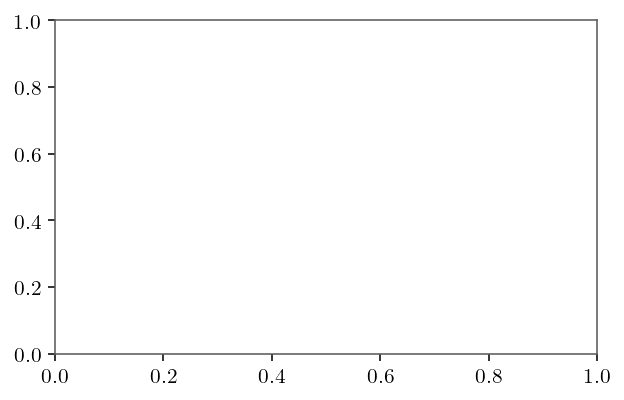

In [19]:
fig, ax = plt.subplots(1, 1, figsize=calculate_fig_dimensions())
print(type(fig), type(ax))